### Logistic Regression Task

- 기계 센서 데이터를 통해 고장 여부를 예측하는 분류기를 모델화한다.

In [1]:
import pandas as pd 

m_df = pd.read_csv('./datasets/machine.csv')
m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


In [2]:
# 결측치 확인
m_df.isna().sum()

Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64

In [3]:
# 중복값 확인
m_df.duplicated().sum()

6

In [4]:
pre_m_df = m_df.drop_duplicates()
pre_m_df.reset_index(drop= True)
pre_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9809,1634,27.9,12,0,0,0,0,0
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0


In [5]:
pre_m_df['Machine failure'].value_counts()

Machine failure
0    9523
1     286
Name: count, dtype: int64

In [6]:
# 언더샘플링 진행
machine_failure_0 = pre_m_df[pre_m_df['Machine failure'] ==0].sample(286, random_state=321)
machine_failure_1 = pre_m_df[pre_m_df['Machine failure'] ==1]

under_m_df = pd.concat([machine_failure_0, machine_failure_1]).reset_index(drop=True)
under_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1548,32.4,81,0,0,0,0,0
1,1350,54.9,153,0,0,0,0,0
2,1818,24.9,9,0,0,0,0,0
3,1635,30.5,159,0,0,0,0,0
4,1642,35.1,149,0,0,0,0,0
...,...,...,...,...,...,...,...,...
567,1352,48.9,238,0,0,0,1,1
568,1294,66.7,12,0,0,1,0,1
569,1360,60.9,187,0,0,0,1,1
570,1337,56.1,206,0,0,0,1,1


In [7]:
under_m_df['Machine failure'].value_counts()

Machine failure
0    286
1    286
Name: count, dtype: int64

In [8]:
import torch
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn.functional import binary_cross_entropy
from sklearn.model_selection import train_test_split
from torch.optim import SGD
import numpy as np

torch.manual_seed(321)

features, targets = under_m_df.iloc[:, :-1], under_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=321)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

logistic_r = Sequential(
    Linear(7, 1),
    Sigmoid()
)

optimizer = SGD(logistic_r.parameters(), lr= 0.1)

epochs = 1000

for epoch in range(1, epochs + 1):
    H = logistic_r(X_train)

    loss = binary_cross_entropy(H, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}/{epochs}')
        for i, w in enumerate(list(logistic_r.parameters())[0][0]):
            print(f'W{i + 1}: {np.round(w.item(), 4)}', end=', ')
        print(f'b: {np.round(list(logistic_r.parameters())[1].item())}\nLoss: {np.round(loss.item(), 4)}')
        print('=' * 90)


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, auc))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [10]:
get_evaluation(y_test.detach(), logistic_r(X_test) >= 0.5)

오차 행렬
[[ 0 58]
 [ 0 57]]
정확도: 0.4957, 정밀도: 0.4957, 재현율: 1.0000, F1: 0.6628, ROC-AUC: 0.5000
################################################################################


### sklearn

In [11]:
from sklearn.linear_model import LogisticRegression

features, targets = under_m_df.iloc[:, :-1], under_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=321)

logistic_r = LogisticRegression(solver='liblinear', penalty='l2', C=0.1, random_state=321)
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)

오차 행렬
[[49  9]
 [ 3 54]]
정확도: 0.8957, 정밀도: 0.8571, 재현율: 0.9474, F1: 0.9000, ROC-AUC: 0.8961
################################################################################


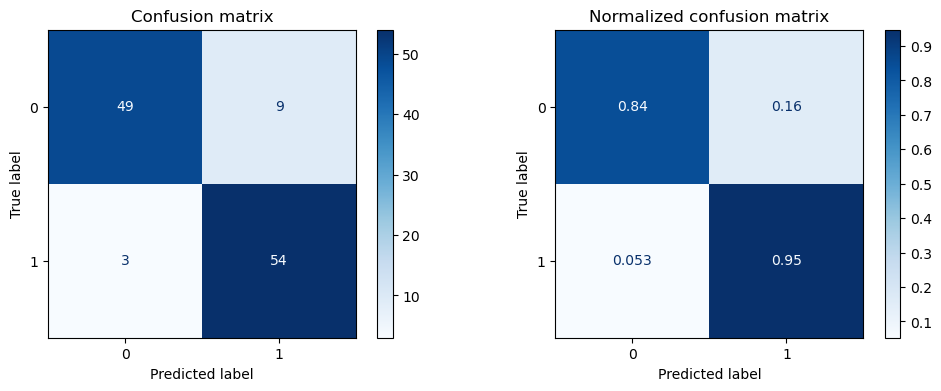

In [12]:
get_evaluation(y_test, prediction, logistic_r, X_test)

In [13]:
# 모델의 가중치 출력
print("가중치:", logistic_r.coef_)

가중치: [[-0.00393833  0.08104051  0.01015431  1.36929055  1.64270908  0.69302463
   0.80224317]]


# 원본 데이터로 확인

In [14]:
import torch
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn.functional import binary_cross_entropy
from sklearn.model_selection import train_test_split
from torch.optim import SGD
import numpy as np

torch.manual_seed(321)

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=321)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

logistic_r = Sequential(
    Linear(7, 1),
    Sigmoid()
)

optimizer = SGD(logistic_r.parameters(), lr= 30)

epochs = 1000

for epoch in range(1, epochs + 1):
    H = logistic_r(X_train)

    loss = binary_cross_entropy(H, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}/{epochs}')
        for i, w in enumerate(list(logistic_r.parameters())[0][0]):
            print(f'W{i + 1}: {np.round(w.item(), 4)}', end=', ')
        print(f'b: {np.round(list(logistic_r.parameters())[1].item())}\nLoss: {np.round(loss.item(), 4)}')
        print('=' * 90)


In [15]:
get_evaluation(y_test.detach(), logistic_r(X_test) >= 0.5)

오차 행렬
[[   0 1905]
 [   0   57]]
정확도: 0.0291, 정밀도: 0.0291, 재현율: 1.0000, F1: 0.0565, ROC-AUC: 0.5000
################################################################################


In [16]:
from sklearn.linear_model import LogisticRegression

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=321)

logistic_r = LogisticRegression(solver='liblinear', penalty='l2', C=1, random_state=321)
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)

오차 행렬
[[1905    0]
 [   7   50]]
정확도: 0.9964, 정밀도: 1.0000, 재현율: 0.8772, F1: 0.9346, ROC-AUC: 0.9386
################################################################################


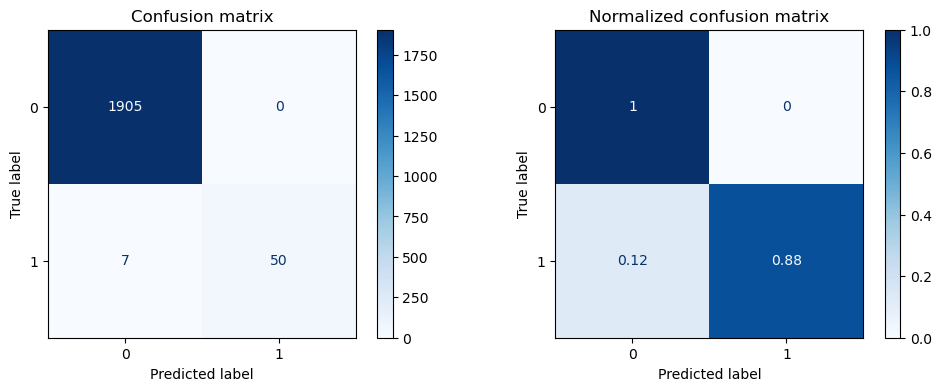

In [17]:
get_evaluation(y_test, prediction, logistic_r, X_test)

# 상관관계 및 다중공선성 확인 후 faeture를 제거 하고 확인.

In [18]:
pre_m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

HDF                       0.628494
OSF                       0.567605
TWF                       0.387342
PWF                       0.387342
Torque [Nm]               0.236346
Tool wear [min]           0.115266
Rotational speed [rpm]   -0.169259
Name: Machine failure, dtype: float64

<Axes: >

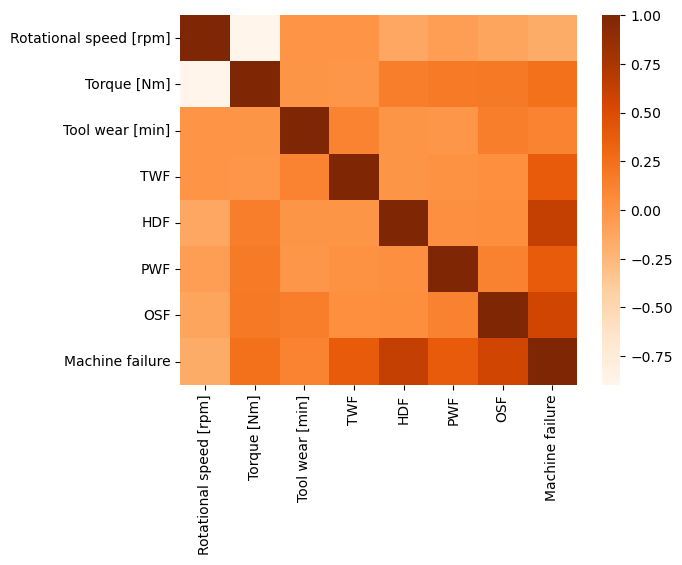

In [19]:
import seaborn as sns 

corr = pre_m_df.corr()
sns.heatmap(corr, cmap='Oranges')

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['feature'] = features.columns
    return vif

In [21]:
get_vif(features)

,vif_score,feature
0,12.358579,Rotational speed [rpm]
1,11.139021,Torque [Nm]
2,4.010943,Tool wear [min]
3,1.019010,TWF
4,1.035623,HDF
5,1.039084,PWF
6,1.075201,OSF


In [22]:
from statsmodels.api import OLS

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:        Machine failure   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          1.492e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        16:42:24   Log-Likelihood:                          15462.
No. Observations:                9809   AIC:                                 -3.091e+04
Df Residuals:                    9802   BIC:                                 -3.086e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [23]:
pre_m_df = pre_m_df.drop(labels = ['Tool wear [min]'], axis = 1)

In [24]:
from sklearn.linear_model import LogisticRegression

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=321)

logistic_r = LogisticRegression(solver='liblinear', penalty='l2', C=1, random_state=321)
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)

오차 행렬
[[1905    0]
 [  10   47]]
정확도: 0.9949, 정밀도: 1.0000, 재현율: 0.8246, F1: 0.9038, ROC-AUC: 0.9123
################################################################################


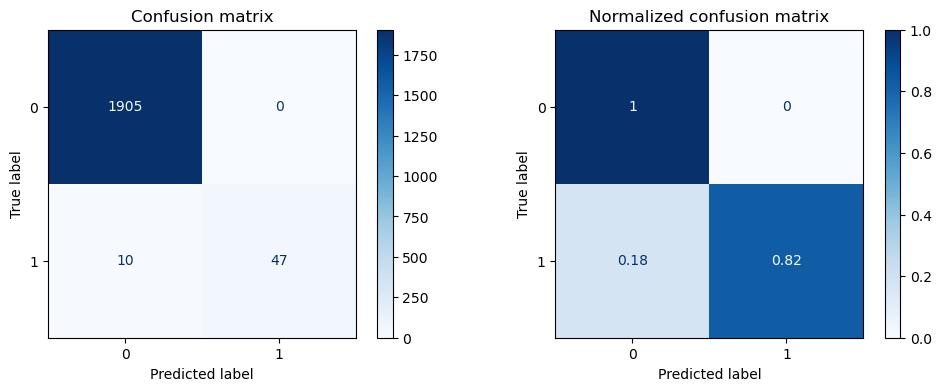

In [25]:
get_evaluation(y_test, prediction, logistic_r, X_test)